In [1]:
import os, pickle
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.decomposition import PCA
from cellpose import models
from openTSNE import TSNE
import warnings
warnings.filterwarnings('ignore')
from imagegrains import data_loader, segmentation_helper, plotting

## Download pre-trained models and demo data  
If you have not donwloaded the pre-trained models and demo data yet from github, please run the following cell to download them.

In [2]:
download_path = data_loader.download_files()
print("Files saved to: ", download_path)

Files saved to:  C:/Users/Mair/imagegrains


## Obtaining image style vectors

In [3]:
#optional: define paths for inference on train (and test set)
impaths = ['F:/cellpose/full_set/train', 'F:/cellpose/full_set/test']
#run inference or load previous results (by default loading style vectors from https://github.com/dmair1989/imagegrains/tree/main/demo_data)
train_styles, trainnames, test_styles, testnames = segmentation_helper.get_style_vectors(do_inference=False)

### Annotate data with tags

In [4]:
# Add data tags
APF_set = ['kanaka','DS8','deer','hidden','L2','K1','S9','GU','Luet','Rhein','Simme','Thur']
S1_set = ['S1']
FH_set = ['P106']
set_tags = []
split_tags = [trainnames,testnames]

for idx, split in enumerate(split_tags):
    for name in split:
        if any (x in name for x in APF_set):
            set_tag = 'APF'
        elif any (x in name for x in S1_set):
            set_tag = 'S1'
        elif any (x in name for x in FH_set):
            set_tag = 'FH'
        else:
            cl_name='unknown'
            set_tag = 'APF'
        set_tags.append(set_tag)

#concatenate train and test data
styles = train_styles + test_styles
styles = np.array(styles)
names = trainnames + testnames
split_tags = ["train"]*len(trainnames) + ["test"]*len(testnames)

# Create anndata object for scanpy (details: https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata)
adata = sc.AnnData(styles)
adata.obs_names= names

# Add data tags
adata.obs["split"] = split_tags
adata.obs["set"] = set_tags

print(adata)

AnnData object with n_obs × n_vars = 81 × 256
    obs: 'split', 'set'


## PCA

In [5]:
#PCA 
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(styles)
X=pca.transform(styles)

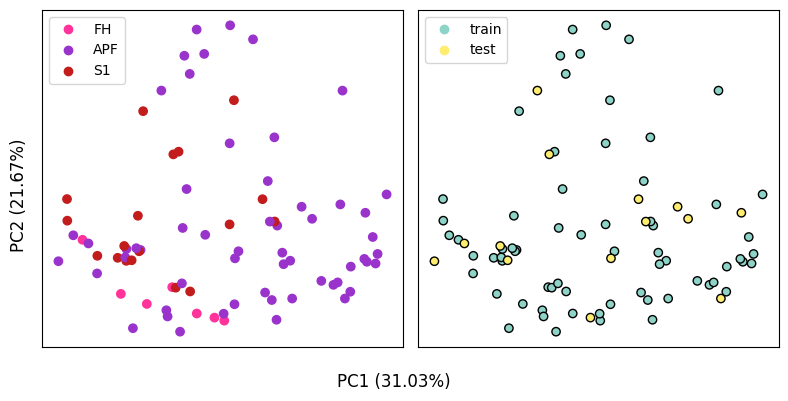

In [6]:
#Plot
set_colours = [[1,0.2,0.6],[0.6,0.2,0.8],[0.760784314,0.109803922,0.109803922]]
set_map =matplotlib.colors.ListedColormap(set_colours)

sets = pd.factorize(set_tags)
splits = pd.factorize(split_tags)

fig, axs = plt.subplots(1,2,figsize=(8,4))

setplot = axs[0].scatter(X[:, 0], X[:, 1], c=sets[0],cmap=set_map)
handles,labels=setplot.legend_elements()
axs[0].legend(handles, sets[1],loc='upper left')

splitplot = axs[1].scatter(X[:, 0], X[:, 1], c=splits[0],edgecolor='k',cmap='Set3')
handles,labels=splitplot.legend_elements()
axs[1].legend(handles, splits[1],loc='upper left')

plt.setp(axs, xticks=(), yticks=())
fig.supxlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100,2)}%)')
fig.supylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100,2)}%)')
plt.tight_layout()

## t-SNE embedding and clustering

In [7]:
# Using the code of Stringer & Pachitariu (2022) from 
# https://github.com/MouseLand/cellpose/blob/main/paper/2.0/train_specialists.py

# Embedding for visualization
# Documentation and details: https://opentsne.readthedocs.io/en/stable/index.html

random_state = 42
n_neighbors = 66
perplexity = 22
resolution = 0.8

tsne = TSNE(    
                neighbors= 'exact',
                perplexity=perplexity,
                metric='cosine',
                n_jobs=8,
                random_state=random_state,
                verbose = False,
                n_components = n_components,
                initialization = .0001 * X,
            )
embeddingOPENTSNE = tsne.fit(styles)
x=embeddingOPENTSNE[:,0]
y=embeddingOPENTSNE[:,1]

#Clustering 
#Using the Leiden algorithm - details: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html#
sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X')
sc.tl.leiden(adata, resolution=resolution)
leiden_labels = np.array(adata.obs['leiden'].astype(int))

### Plot style cluster in tSNE plot

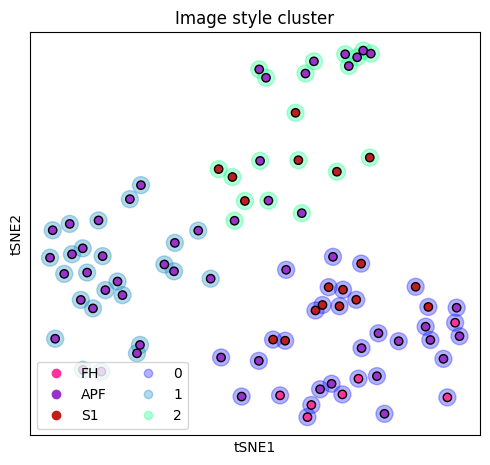

In [8]:
fig = plt.figure(figsize=(5,5))

#plot clustered data with leiden labels
clusterplot=plt.scatter(x,y,s=150,c=leiden_labels,alpha=.3,cmap='winter')

#plot data with dataset tags
sourceplot=plt.scatter(x,y,c=sets[0],edgecolor='k',cmap=set_map)

#configure axes
handles,labels=sourceplot.legend_elements()
handles2,labels=clusterplot.legend_elements()
ax = plt.gca()
plt.setp(ax, xticks=(), yticks=(), xlabel='tSNE1',ylabel='tSNE2',aspect = 'equal')

#display file names
#for (xi, yi, txt) in zip(x, y, names):
#    plt.text(xi, yi, txt, va='bottom', ha='center',fontsize=8)

#plot legend
handles = handles + handles2
s = [str(sets[1][k]) for k in range(len(sets[1]))]
l = [str(np.unique(leiden_labels)[k]) for k in range(len(np.unique(leiden_labels)))]
plt.legend(handles, s+l,loc='lower left',ncol=2)
plt.title('Image style cluster')
plt.tight_layout()

### Plot style cluster in PC plot

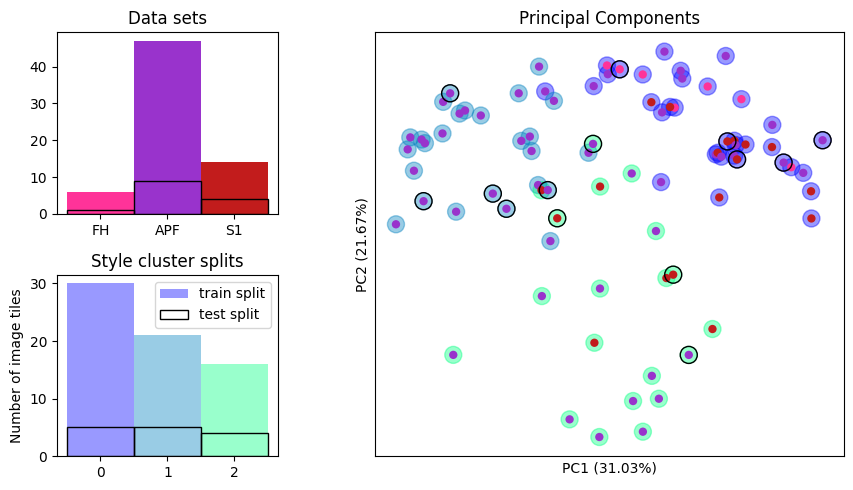

In [9]:
fig = plt.figure(figsize=(11,5))
cmap2 = matplotlib.cm.get_cmap('winter')
rgba2 = [cmap2(x) for x in np.linspace(0, 1, 3)]
plt.subplot(1,2,2)
plt.scatter(X[:, 0], X[:, 1], c=leiden_labels,s=150,alpha=0.4,cmap='winter')
plt.scatter(X[:, 0], X[:, 1], c=sets[0],edgecolor='none',cmap=set_map)

plt.scatter(X[:,0][67:], X[:,1][67:], s=150, color='none',edgecolor='k')
handles,labels=splitplot.legend_elements()

plt.xticks(())
plt.yticks(());
plt.title('Principal Components')

plt.xlabel(f'PC1 ({np.round(pca.explained_variance_ratio_[0]*100,2)}%)')
plt.ylabel(f'PC2 ({np.round(pca.explained_variance_ratio_[1]*100,2)}%)')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.subplot(2,4,2)
_, _, patches = plt.hist(set_tags[0:len(trainnames)], bins=np.arange(4)-0.5,label='train')  
for i in range(3):
    patches[i].set_fc(set_colours[i])  
_, _, patches2 =plt.hist(set_tags[len(trainnames):],bins=np.arange(4)-0.5,edgecolor='k',label='test',facecolor='none')
plt.title('Data sets')

plt.subplot(2,4,6)
_, _, patches = plt.hist(leiden_labels[0:len(trainnames)], bins=np.arange(4)-0.5,alpha=0.4,label='train')  
for i in range(3):
    patches[i].set_fc(rgba2[i][:3])  
_, _, patches2 =plt.hist(leiden_labels[len(trainnames):],bins=np.arange(4)-0.5,edgecolor='k',label='test',facecolor ='none')
plt.ylabel('Number of image tiles')
plt.xticks([0,1,2],[str(np.unique(leiden_labels)[k]) for k in range(len(np.unique(leiden_labels)))])

plt.legend(['train split','test split'])
plt.title('Style cluster splits')
plt.tight_layout()